In [19]:
import os

from tqdm.notebook import tqdm

tqdm.pandas()
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import imagesize

from bbox.utils import clip_bbox, str2annot, annot2str
from bbox.utils import coco2yolo, coco2voc, voc2yolo, yolo2voc, draw_bboxes

from joblib import Parallel, delayed
from multiprocessing import Pool

import warnings
warnings.filterwarnings('ignore')

In [2]:
def get_imgsize(row):
    row['width'], row['height'] = imagesize.get(row['image_path'])
    return row

def load_image(path):
    return cv2.imread(path)[...,::-1]

### Config

In [3]:
PROJECT_PATH = '/media/storage3/data3T/happy_whale/'

IMG_SIZE = (256, 256) # new image resolution
CONF = 0.01 # confidence threshold for bbox

train_output = os.path.join(PROJECT_PATH, 'output/train')
test_output = os.path.join(PROJECT_PATH, 'output/test')

### Meta Data

In [13]:
df = pd.read_csv(os.path.join(PROJECT_PATH, "train.csv"))
df["image_id"] = df["image"]
df["image_path"] = f"{PROJECT_PATH}/train_images/" + df.image_id
df["label_path"] = train_output + "/labels/" + df["image_id"].str.replace('jpg','txt')

test_df = pd.DataFrame(
    data={
        'image': os.listdir(
            os.path.join(
                PROJECT_PATH, 'test_images'
            )
        )
    }
)
test_df["image_id"] = test_df["image"]
test_df["image_path"] = f"{PROJECT_PATH}/test_images/" + test_df.image_id
test_df["label_path"] = test_output + "/labels/" + test_df["image_id"].str.replace('jpg','txt')

print("Train Images: {:,} | Test Images: {:,}".format(len(df), len(test_df)))

Train Images: 51,033 | Test Images: 27,956


In [15]:
full_train_labes_path = list(
    map(lambda x:
        train_output + "/labels/" + x,
        os.listdir('/media/storage3/data3T/happy_whale/output/train/labels/')
       )
)

df = df[df['label_path'].isin(full_train_labes_path)]

full_test_labes_path = list(
    map(lambda x:
        test_output + "/labels/" + x,
        os.listdir('/media/storage3/data3T/happy_whale/output/test/labels/')
       )
)

test_df = test_df[test_df['label_path'].isin(full_test_labes_path)]

print("Train Images: {:,} | Test Images: {:,}".format(len(df), len(test_df)))

Train Images: 50,286 | Test Images: 27,529


In [17]:
df = df.progress_apply(get_imgsize, axis=1)
test_df = test_df.progress_apply(get_imgsize, axis=1)

  0%|          | 0/50286 [00:00<?, ?it/s]

  0%|          | 0/27529 [00:00<?, ?it/s]

In [49]:
%%time
def parse_labels(any_df):
    yolo_arr = []
    voc_arr = []
    for row in any_df.itertuples():

        with open(row.label_path) as f:
            txt = f.read()
            txt = txt.split('\n')[0]
            txt = ' '.join(txt.split(' ')[:-1])
            annot = str2annot(txt)

        bboxes_yolo = annot[...,1:]
        bboxes_yolo_copy = bboxes_yolo.copy()
        bbox_voc = yolo2voc(bboxes_yolo, height=row.height, width=row.width)

        yolo_arr.append(bboxes_yolo_copy)
        voc_arr.append(bbox_voc)
        
    return voc_arr

# функция для мультипроцессных запросов
def main(any_df):
    agg_results = []
    threads = 16
    chunks = np.array_split(any_df, threads)
    with Pool() as p:
        try:
            results = p.map(parse_labels, chunks)
            agg_results.append(results)
        except Exception as e:
            print(e)
    return agg_results

if __name__ == '__main__':
    res_train = main(df)
    res_test = main(test_df)

resp_list_s = [lists for sub in res_train for lists in sub]
sub_list = [x for sub in resp_list_s for x in sub]
voc_arr_train = [x for sub in sub_list for x in sub]

resp_list_s = [lists for sub in res_test for lists in sub]
sub_list = [x for sub in resp_list_s for x in sub]
voc_arr_test = [x for sub in sub_list for x in sub]

df['bbox_voc'] = voc_arr_train
test_df['bbox_voc'] = voc_arr_test

CPU times: user 394 ms, sys: 205 ms, total: 599 ms
Wall time: 14.9 s


In [54]:
df.to_csv(os.path.join(PROJECT_PATH, 'train_bbox.csv'), index=False)
test_df.to_csv(os.path.join(PROJECT_PATH, 'test_bbox.csv'), index=False)

### Plot examples

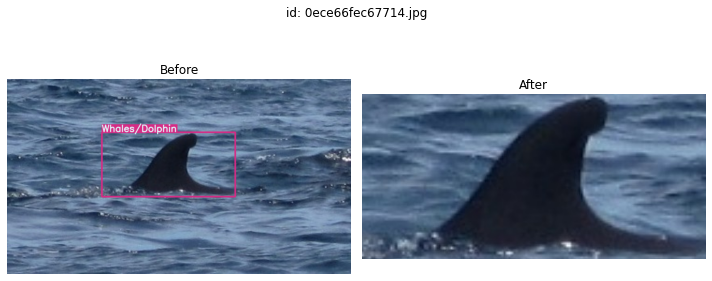

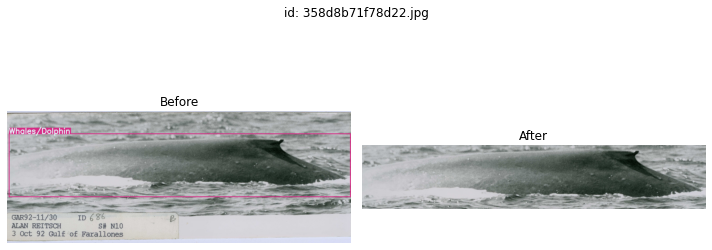

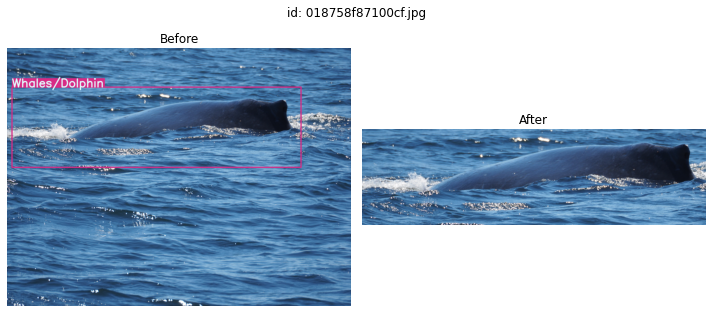

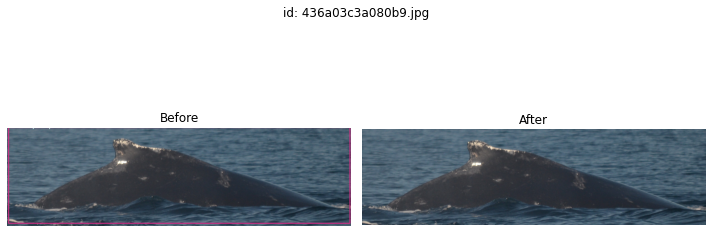

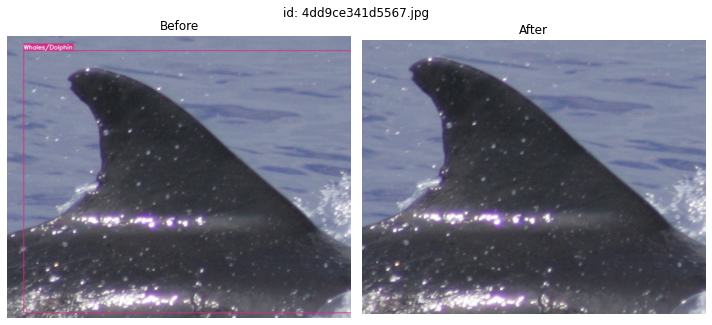

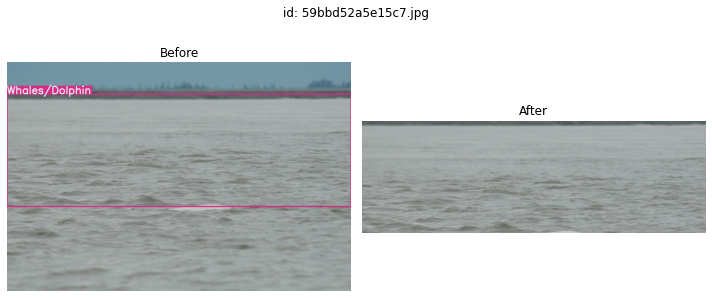

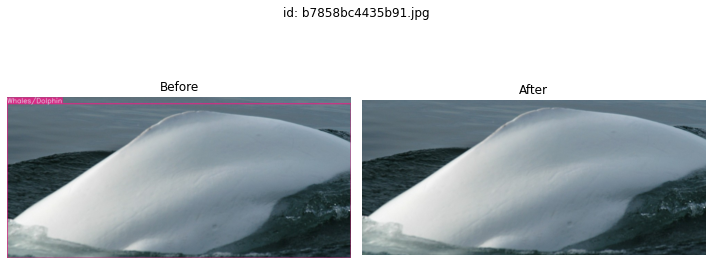

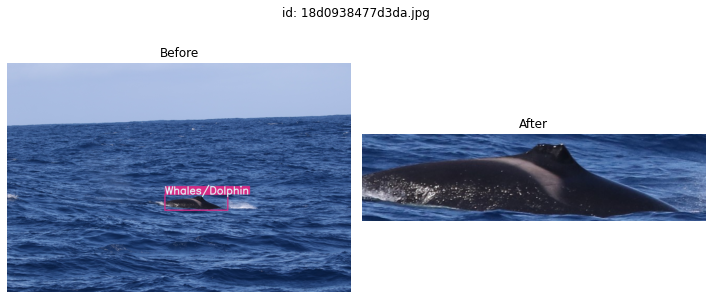

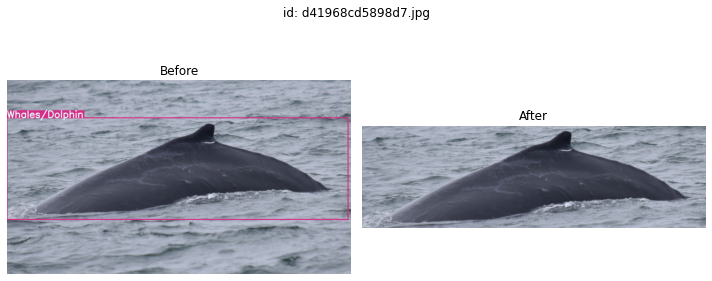

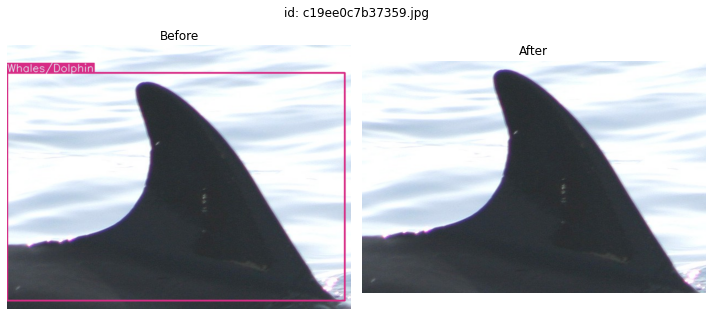

In [68]:
np.random.seed(32)
colors = [(np.random.randint(255), np.random.randint(255), np.random.randint(255))\
          for idx in range(1)]

for i in range(10):
    row = df.sample(frac=1.0).iloc[i]
    img = load_image(row.image_path)
    bbox = row['bbox_voc']
    xmin, ymin, xmax, ymax = bbox
    xmin, ymin, xmax, ymax = int(xmin), int(ymin), int(xmax), int(ymax)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    dim = np.sqrt(np.prod(img.shape[:2]))
    line_thickness = int(2/512*dim)
    plt.imshow(
            draw_bboxes(
                img=img,
                bboxes=np.array([row['bbox_voc']]),
                classes=['Whales/Dolphin'],
                class_ids=[0],
                class_name=True,
                colors=colors,
                bbox_format="voc",
                line_thickness=line_thickness,
            ))
    plt.title('Before')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img[ymin:ymax, xmin:xmax])
    plt.title('After')
    plt.axis('off')
    
    plt.suptitle(f'id: {row.image_id}', y=0.94)
    plt.tight_layout()
    plt.show()

### Crop if needed

In [ ]:
def crop_image(row):
    image_path = row['image_path']
    if 'train' in image_path:
        save_dir = os.path.join(train_output, 'train_images')
    else:
        save_dir = os.path.join(test_output, 'test_images')
    img = load_image(image_path)
    if len(row['bbox_voc']): # if there is no bbox
        bbox = row['bbox_voc'][0]
    img = cv2.resize(img[...,::-1], dsize=IMG_SIZE, interpolation=cv2.INTER_AREA)
    cv2.imwrite(f'{save_dir}/{row.image_id}', img) # save image in the new directory

In [76]:
!mkdir -p /media/storage3/data3T/happy_whale/output/train/train_images

In [77]:
# Train
_ = Parallel(n_jobs=-1, backend='threading')(
    delayed(crop_image)(row) for _, row in tqdm(t_df.iterrows(), total=len(t_df), desc='train'))

train:   0%|          | 0/100 [00:00<?, ?it/s]